# Compare seismic features with geodetic data

These features were calculated on the `kebo` machine with  approximately ten years of continuous data (broadband and three-components). They used long-duration windows (typically half hour long) and twenty-ish components and clusters. The goal is to investigate the relationship with the geodetic data.

In [1]:
import os
import pickle

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import figures

## Global parameters

In [2]:
NETWORK = "network_1"
POOLING = "max"
REDUCTION = "fastica_20"
CLUSTERING = "kmeans_15"
SUFFIX = f"{REDUCTION}_{CLUSTERING}"
DIRPATH_FIGURES = f"./paper/hf/{POOLING}"
FILEPATH_DATABASE = "./data/mseed_database/IG.ARIG.BH.sqlite-index.pkl"
FILEPATH_NETWORK = f"./model/{NETWORK}.pkl"
FILEPATH_SCATTERINGS = f"./out/{NETWORK}_{POOLING}.pkl"
FILEPATH_CLUSTERS = f"./out/{NETWORK}_{POOLING}_{SUFFIX}.pkl"
FILEPATH_CATALOG = "./data/catalogs/tremors_S1_husker.csv"
FILEPATH_GPS = "data/gps/gps_detrended_smooth_10.pkl"

# Create the directory for the figures if it does not exist.
os.makedirs(DIRPATH_FIGURES, exist_ok=True)

# Print out file
print(f"Filepath database: {FILEPATH_DATABASE}")
print(f"Filepath network: {FILEPATH_NETWORK}")
print(f"Filepath scatterings: {FILEPATH_SCATTERINGS}")
print(f"Filepath clusters: {FILEPATH_CLUSTERS}")
print(f"Filepath catalog: {FILEPATH_CATALOG}")
print(f"Dirpath figures: {DIRPATH_FIGURES}")

Filepath database: ./data/mseed_database/IG.ARIG.BH.sqlite-index.pkl
Filepath network: ./model/network_1.pkl
Filepath scatterings: ./out/network_1_max.pkl
Filepath clusters: ./out/network_1_max_fastica_20_kmeans_15.pkl
Filepath catalog: ./data/catalogs/tremors_S1_husker.csv
Dirpath figures: ./paper/hf/max


## Read results

Some outputs were downloaded locally.

In [3]:
# Load the features
data = pickle.load(open(FILEPATH_CLUSTERS, "rb"))
print(f"Clusters loaded from {FILEPATH_CLUSTERS}")

# Load the gps data
gps = pickle.load(open(FILEPATH_GPS, "rb"))
print(f"Geodetic data loaded from {FILEPATH_GPS}")

# Get if x is features or clusters
x_feature_name = "cluster"
n_features = len(data.cluster)

Clusters loaded from ./out/network_1_max_fastica_20_kmeans_15.pkl
Geodetic data loaded from data/gps/gps_detrended_smooth_10.pkl


## Everybody on the same page (interpolate on same dates)

We also observe the smoothed features in order to better investigate long-duration trends in the features. We do this with a rolling windows associated with a mean. The result is non-causal (centered) with a minimum sample of 1.

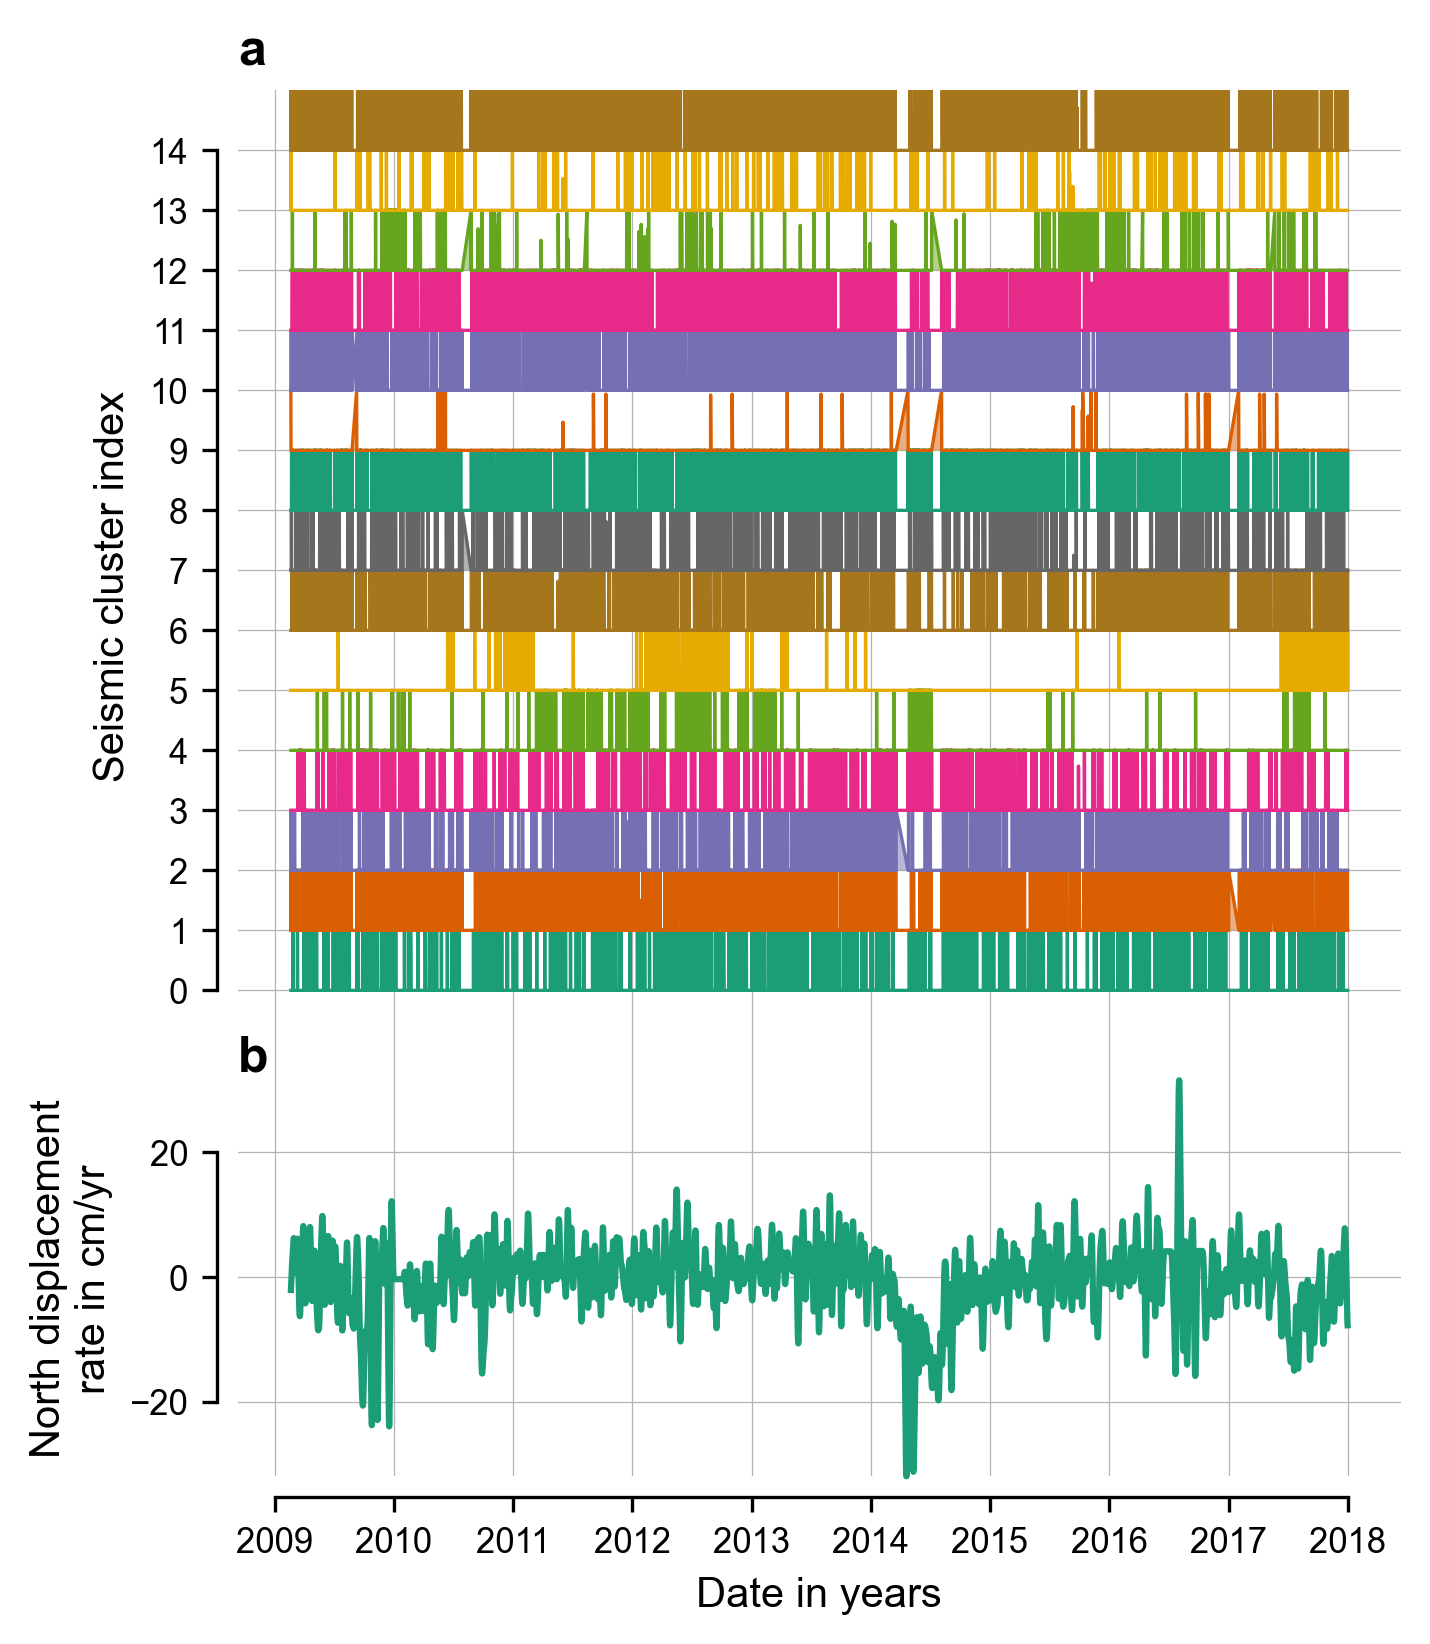

In [4]:
# Define a common time axis
start = max(gps.time.min(), data.time.min())
end = min(gps.time.max(), data.time.max())
step = np.timedelta64(6, "h")
times = np.arange(start.data, end.data, step)

# Interpolate
x_interp = data.clusters.copy()  #rolling(time=30 * 2 * 24, center=True).mean()
x_slow = x_interp.interp(time=times)
x_slow = x_slow.dropna("time")

# Normalize
x_norm = x_slow.copy()
x_norm /= x_norm.max()

# Limit y to the same time period as x
gps = gps.sel(time=slice(data.time.min(), data.time.max()))

# Resample and interpolate
y_interp = gps.resample(time="6h").interpolate().interp(time=x_slow.time)

# Plot
sns.set_palette("Dark2")
ax = figures.compare(x_norm, y_interp, components=("north",))

# Subplots
ax[0].set_ylim(-1.5, len(x_norm.cluster))
ax[0].set_yticks(np.arange(len(x_norm.cluster)))
ax[0].set_title("a", loc="left")
ax[1].set_title("b", loc="left", pad=-20, va="top")
sns.despine(ax=ax[0], trim=True, offset=5, bottom=True)
sns.despine(ax=ax[1], trim=True, offset=5)

# Show 
ax[0].figure.savefig(f"{DIRPATH_FIGURES}/e2_prepare_{SUFFIX}.pdf", bbox_inches="tight")

## Cluster-wise velocity distribution

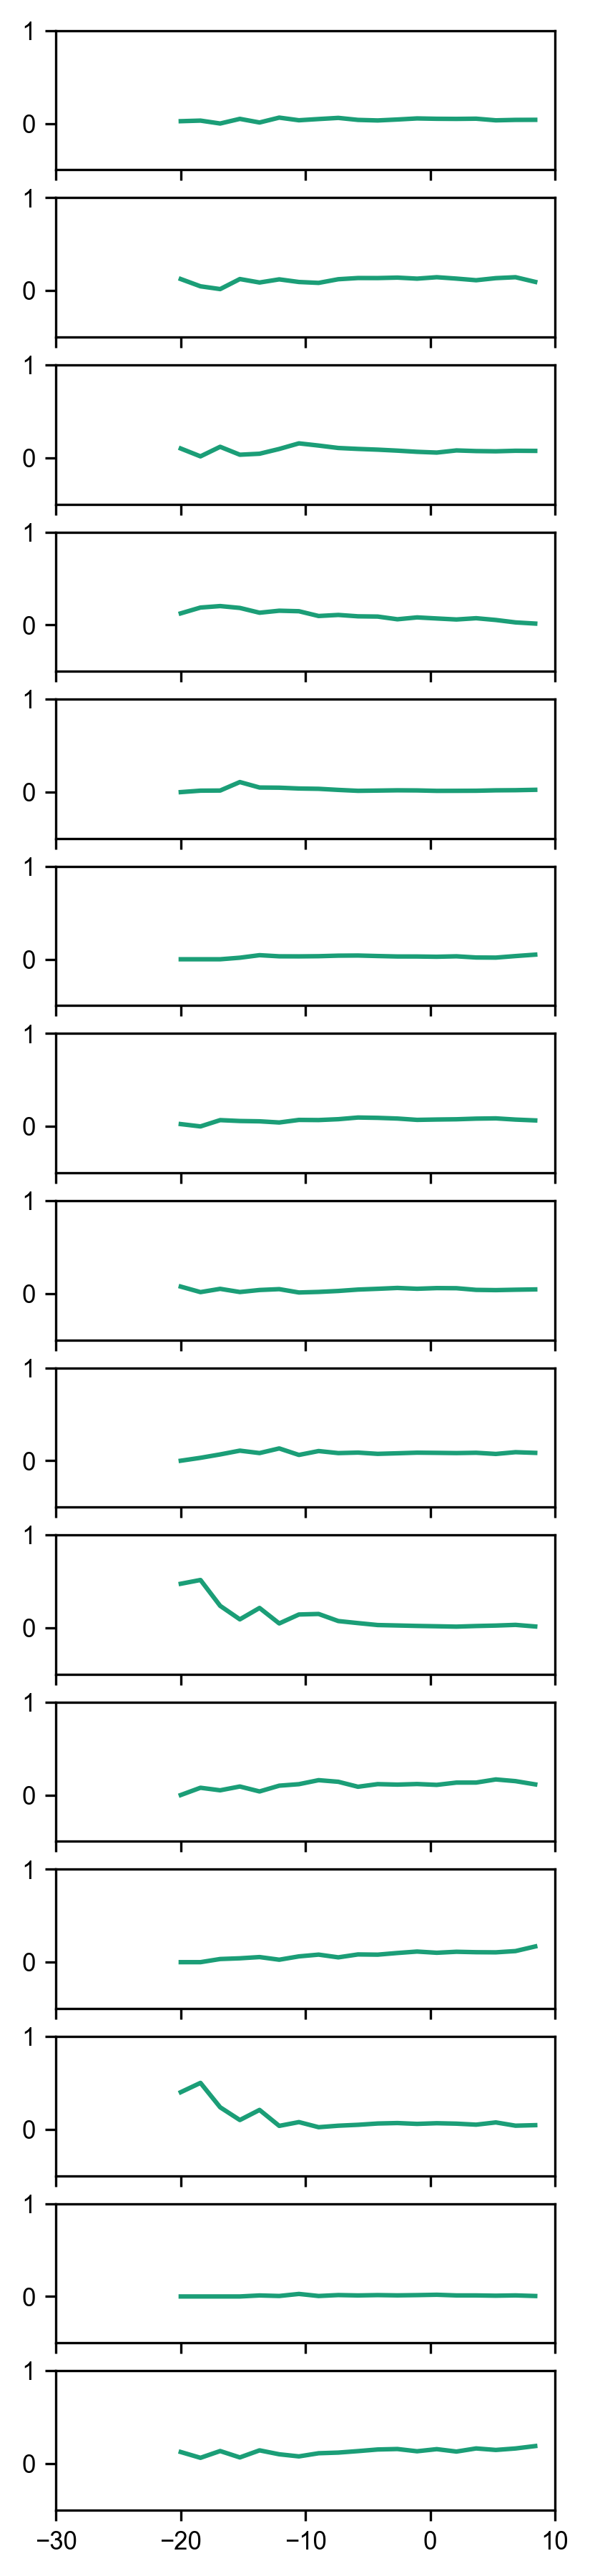

In [10]:
fig, ax = plt.subplots(nrows=len(x_slow.cluster), sharex=True, sharey=True, figsize=(3, 15))
bins = np.linspace(-20, 10, 20)
obs_all, _ = np.histogram(y_interp.sel(component="north").values, bins=bins)
for cluster in x_slow.cluster.values:
    obs = y_interp.sel(component="north").copy().values[x_slow.sel(cluster=cluster) > 0]
    obs, _ = np.histogram(obs, bins=bins)
    obs = obs / obs_all
    ax[cluster].plot(bins[:-1], obs)
    # ax[cluster].set_title("")

## Contributions

NameError: name 'model' is not defined

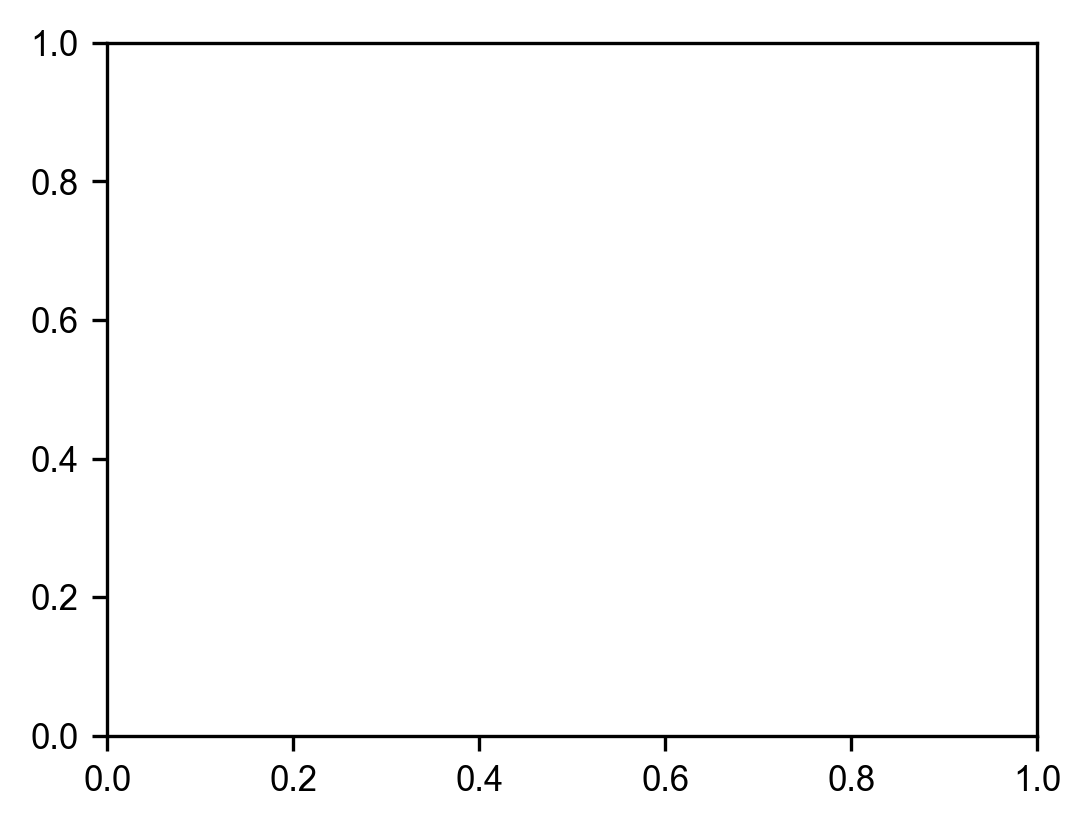

In [11]:
fig = plt.figure()
ax = plt.axes()

# Contributions
contributions = model.coef_ * design.mean(dim="time")

# Plot
sns.barplot(x=np.arange(len(model.coef_)), y=contributions, palette="Dark2", ax=ax)

# Seaborn style
ax.grid(True, axis="y")
sns.despine(ax=ax, offset=5, trim=True)
ax.set_xlabel("Seismic cluster index")
ax.set_ylabel("Displacement rate\nper window (mm/yr)")

# Save
plt.savefig(f"{DIRPATH_FIGURES}/e3_contributions_{EXPO}_{SUFFIX}.pdf", bbox_inches="tight")

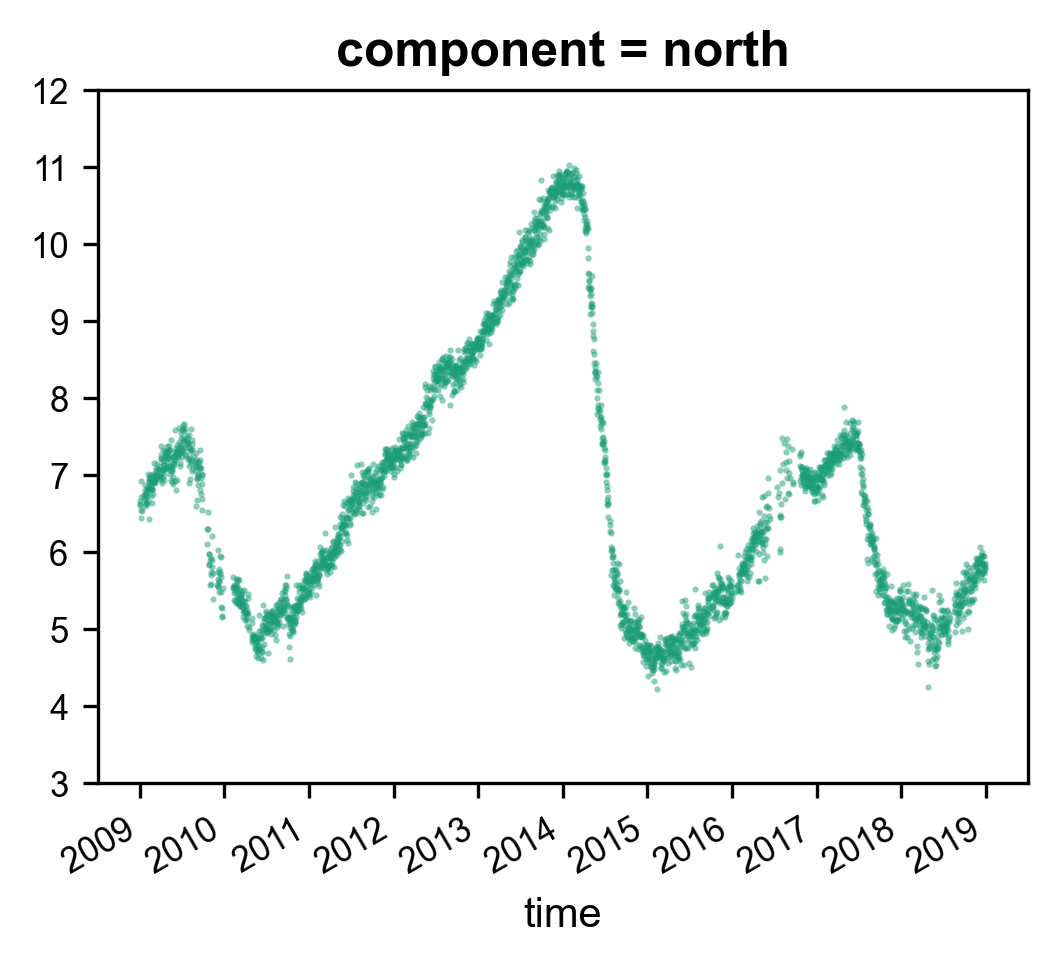

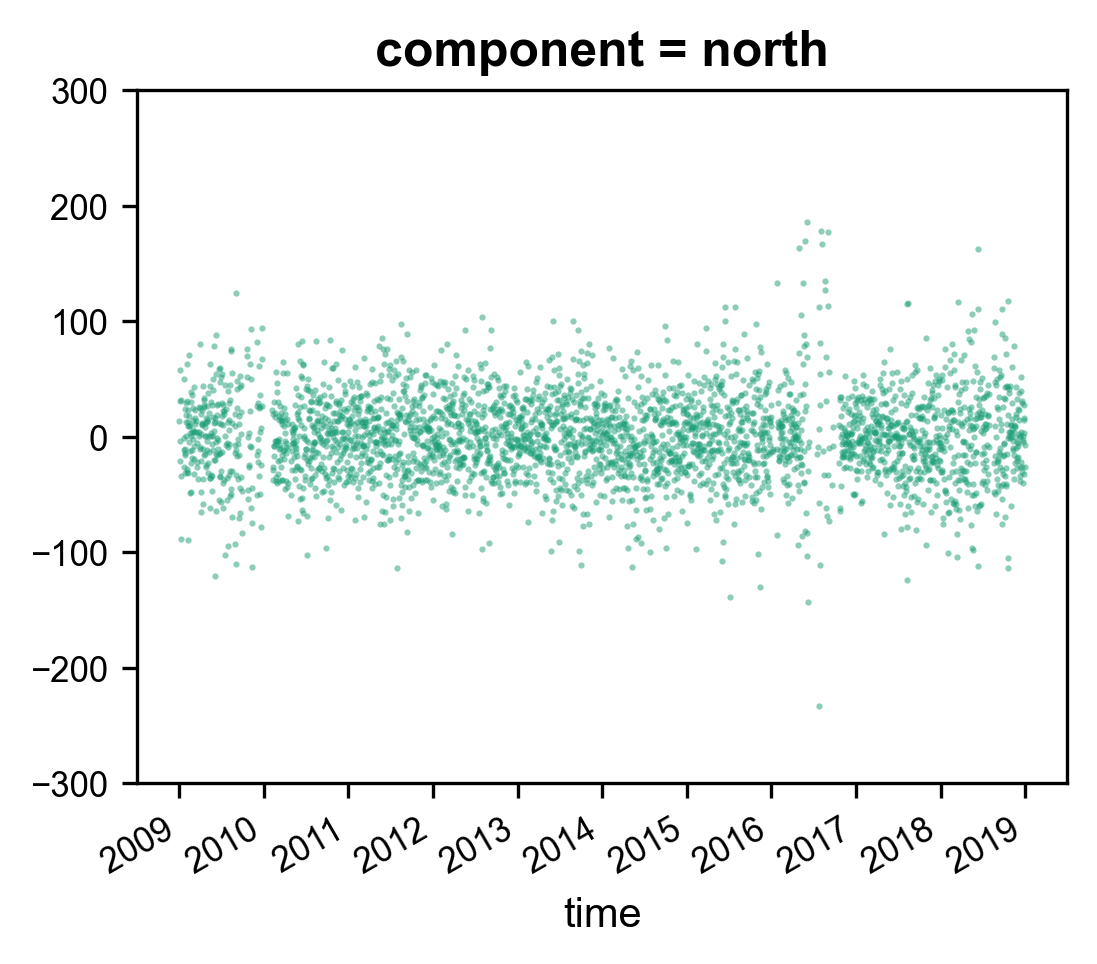

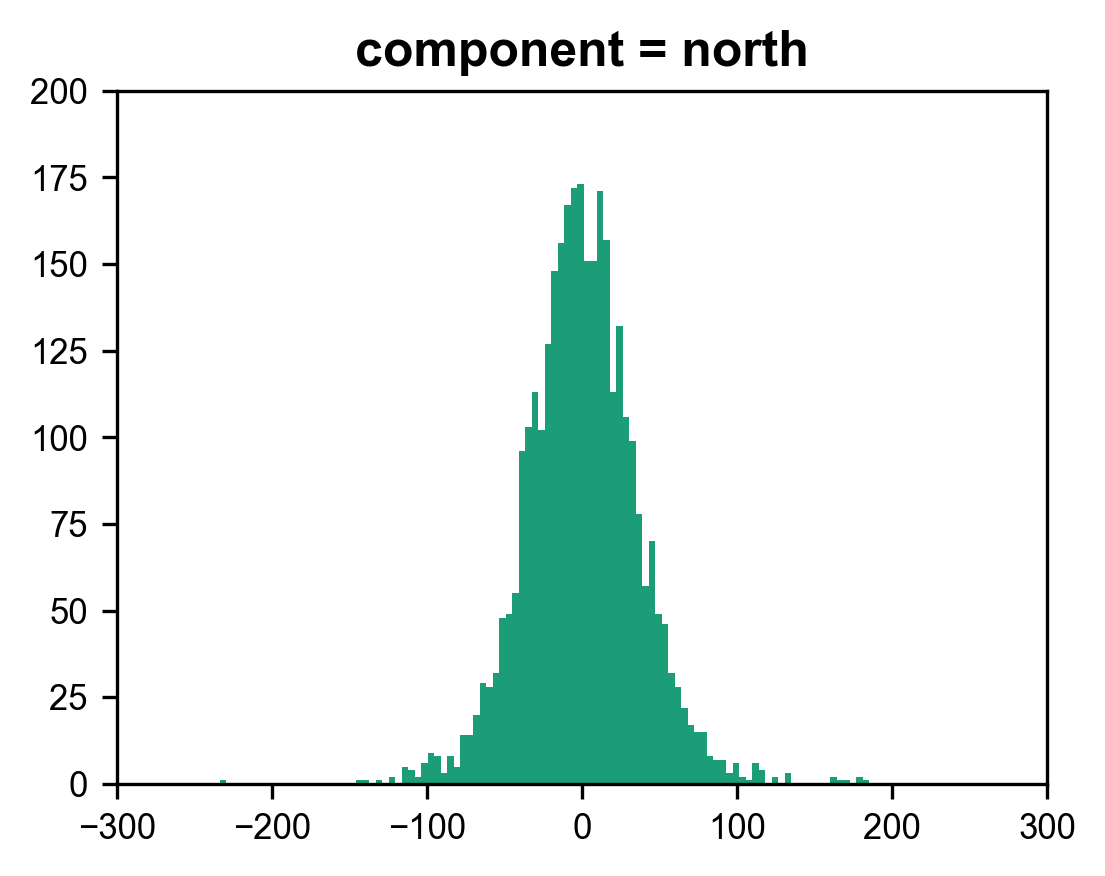

In [12]:
import caya

gps = caya.read("data/gps/CAYA.dat")
gps = gps.sel(time=slice("2009", "2018"))

component = gps.sel(component="north")
component.plot(marker=".", linestyle="None", alpha=0.5, mew=0, ms=3)
plt.show()

component_diff = component.differentiate("time", datetime_unit="D")
component_diff *= 365
component_diff.plot(marker=".", linestyle="None", alpha=0.5, mew=0, ms=3)
plt.show()

component_diff.plot.hist(bins=100)
plt.show()

In [13]:
# data.clusters.interp(time=component.time).sel(cluster=3).plot()
# data.clusters.interp(time=component.time).sum().sel(cluster=3).plot()
counts = list()
for row in component:
    end = row.time + np.timedelta64(1, "D")
    c = data.clusters.sel(time=slice(row.time, end))
    counts.append(c.sum(dim="time"))

In [14]:
counts = np.array(counts)

In [22]:
import xarray as xr
clusters_gps = xr.DataArray(counts, coords=[component.time, data.cluster], dims=["time", "cluster"])
# clusters_gps.sel(cluster=8).plot()


In [51]:
bins = np.linspace(-100, 100, 50)
digits = np.digitize(component_diff.values, bins=bins)
np.unique(digits)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

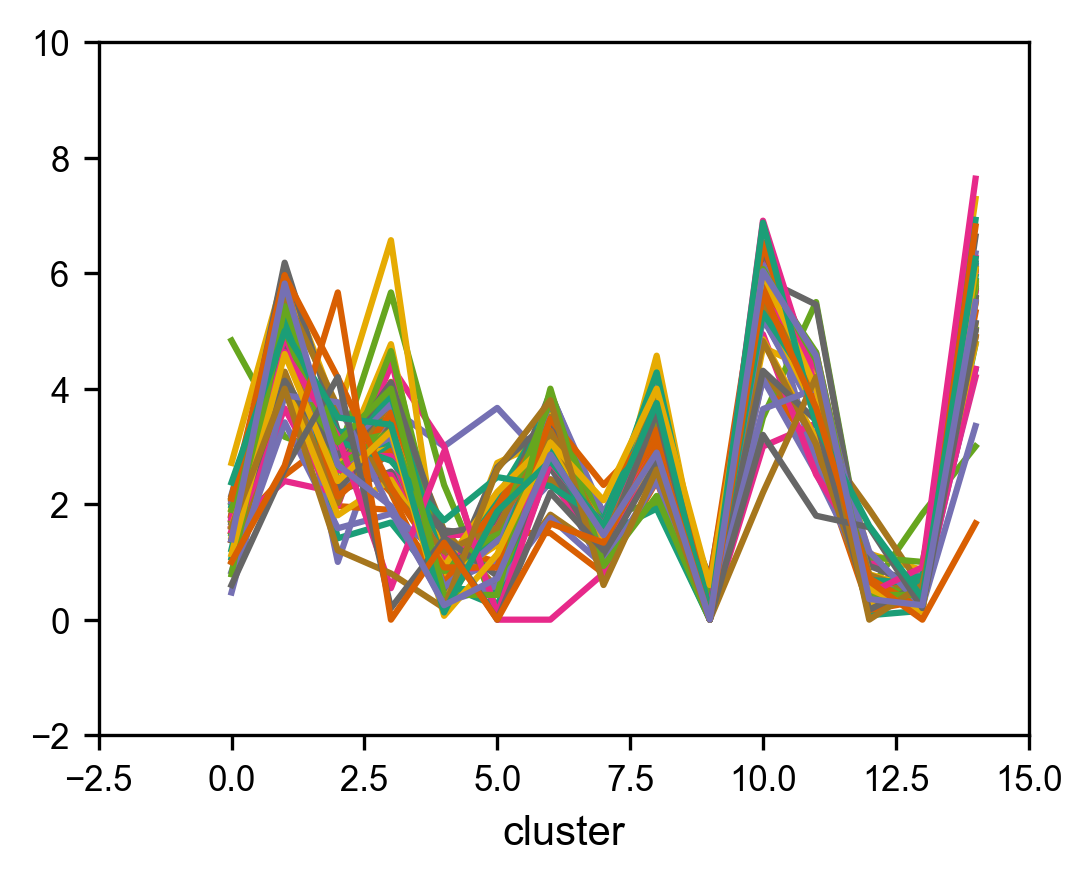

In [50]:
for digit in np.unique(digits):
    (clusters_gps.loc[digits == digit].sum(dim="time") / (digits == digit).sum()).plot()
# for i, digit in enumerate(np.unique(digits)):
#     clusters_gps.values[i] *= digit